# Training Pipeline

# Imports
## Pip Packages

In [1]:
import os
from torch.utils.data import DataLoader

if not os.path.exists('data'):
    new_directory_path = "..\\..\\"
    os.chdir(new_directory_path)

from tqdm import tqdm

from src.parsers import CocoFreeView
from src.preprocess.simulation import gen_gaze, downsample
from src.preprocess.noise import add_random_center_correlated_radial_noise
from src.datasets import FreeViewInMemory, seq2seq_collate_fn

# Load Dataset

In [10]:
# TODO Implement Strategy and Builder pattern
datasetv2 = FreeViewInMemory(sample_size= 8,log = True, start_index=0)


Data loaded in memory


## Speed Test

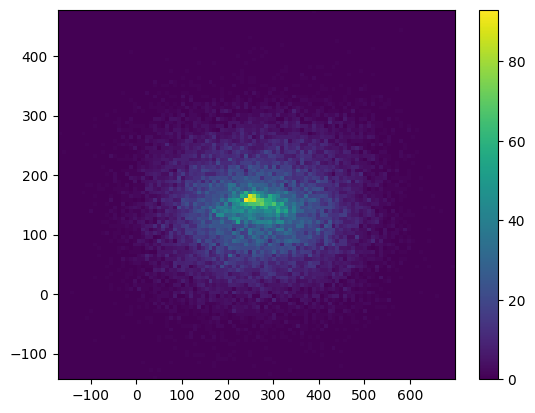

In [11]:
import matplotlib.pyplot as plt

# for i in tqdm(range(len(datasetv2))):
acum_x = []
acum_y = []
for i in range(len(datasetv2)):
    x,y = datasetv2[i]
    acum_x.append(x[0,0])
    acum_y.append(x[1,0])


plt.hist2d(acum_x, acum_y, bins=100)
plt.colorbar()
plt.show()


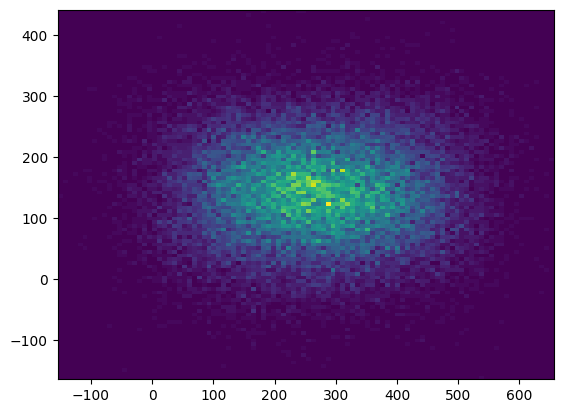

In [ ]:
import matplotlib.pyplot as plt

# for i in tqdm(range(len(datasetv2))):
acum_x = []
acum_y = []
for i in range(len(datasetv2)):
    x,y = datasetv2[i]
    acum_x.append(x[0,0])
    acum_y.append(x[1,0])



plt.hist2d(acum_x, acum_y, bins=100)
plt.show()


In [5]:


dataloader = DataLoader(datasetv2, batch_size=128, shuffle=True, num_workers=0, collate_fn= seq2seq_collate_fn)
for batch in tqdm(dataloader):
    x,y = batch

100%|██████████| 274/274 [00:01<00:00, 233.75it/s]


In [ ]:
# dataset = PathCocoFreeViewDatasetBatch(sample_size= 8,log = True)
# dataset.close_and_remove_data()

# dataset.close_and_remove_data()
# dataset.shuffle_dataset()


# for i in tqdm(range(len(dataset))):
#     dataset[i]

reading original data
shuffled data saved


# Transformer Model
## Eye-tracking Sequence Transformer

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

In [ ]:
class PositionalEncoding(nn.Module):
    """
    Positional encoding for transformer inputs.
    Adds position information to the input embeddings.
    """
    def __init__(self, d_model: int, max_len: int = 5000):
        super().__init__()
        
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * 
                           (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        """
        Args:
            x: Tensor of shape [seq_len, batch_size, d_model]
        """
        return x + self.pe[:x.size(0), :]

In [ ]:
class EyeTrackingTransformer(nn.Module):
    """
    Transformer model for eye-tracking sequence prediction.
    Processes sequences of eye-tracking data (x, y, time) and predicts fixation sequences.
    """
    
    def __init__(
        self,
        input_dim: int = 3,  # x, y, time coordinates
        d_model: int = 256,
        nhead: int = 8,
        num_encoder_layers: int = 6,
        num_decoder_layers: int = 6,
        dim_feedforward: int = 1024,
        dropout: float = 0.1,
        max_seq_length: int = 1000,
        output_dim: int = 3  # x, y, time for fixations
    ):
        super().__init__()
        
        self.d_model = d_model
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        # Input projection layers
        self.input_projection = nn.Linear(input_dim, d_model)
        self.output_projection = nn.Linear(d_model, output_dim)
        
        # Positional encoding
        self.pos_encoder = PositionalEncoding(d_model, max_seq_length)
        
        # Transformer
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=False  # seq_len, batch_size, features
        )
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
        # Initialize weights
        self._init_weights()
        
    def _init_weights(self):
        """Initialize model weights."""
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
    
    def _generate_square_subsequent_mask(self, sz: int) -> torch.Tensor:
        """Generate causal mask for decoder."""
        mask = torch.triu(torch.ones(sz, sz), diagonal=1)
        mask = mask.masked_fill(mask == 1, float('-inf'))
        return mask
    
    def forward(
        self, 
        src: torch.Tensor, 
        tgt: torch.Tensor,
        src_key_padding_mask: torch.Tensor = None,
        tgt_key_padding_mask: torch.Tensor = None
    ) -> torch.Tensor:
        """
        Forward pass of the transformer.
        
        Args:
            src: Source sequence [seq_len, batch_size, input_dim]
            tgt: Target sequence [seq_len, batch_size, output_dim]  
            src_key_padding_mask: Mask for source padding [batch_size, seq_len]
            tgt_key_padding_mask: Mask for target padding [batch_size, seq_len]
            
        Returns:
            output: Predicted sequence [seq_len, batch_size, output_dim]
        """
        # Project input to model dimension
        src = self.input_projection(src) * math.sqrt(self.d_model)
        tgt = self.input_projection(tgt) * math.sqrt(self.d_model)
        
        # Add positional encoding
        src = self.pos_encoder(src)
        tgt = self.pos_encoder(tgt)
        
        # Apply dropout
        src = self.dropout(src)
        tgt = self.dropout(tgt)
        
        # Generate causal mask for decoder
        tgt_mask = self._generate_square_subsequent_mask(tgt.size(0)).to(tgt.device)
        
        # Pass through transformer
        output = self.transformer(
            src=src,
            tgt=tgt,
            tgt_mask=tgt_mask,
            src_key_padding_mask=src_key_padding_mask,
            tgt_key_padding_mask=tgt_key_padding_mask
        )
        
        # Project back to output dimension
        output = self.output_projection(output)
        
        return output
    
    def encode(self, src: torch.Tensor, src_key_padding_mask: torch.Tensor = None) -> torch.Tensor:
        """
        Encode source sequence.
        
        Args:
            src: Source sequence [seq_len, batch_size, input_dim]
            src_key_padding_mask: Mask for source padding [batch_size, seq_len]
            
        Returns:
            memory: Encoded sequence [seq_len, batch_size, d_model]
        """
        # Project and add positional encoding
        src = self.input_projection(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        src = self.dropout(src)
        
        # Encode
        memory = self.transformer.encoder(src, src_key_padding_mask=src_key_padding_mask)
        return memory
    
    def decode(
        self, 
        tgt: torch.Tensor, 
        memory: torch.Tensor,
        tgt_key_padding_mask: torch.Tensor = None,
        memory_key_padding_mask: torch.Tensor = None
    ) -> torch.Tensor:
        """
        Decode target sequence given encoded memory.
        
        Args:
            tgt: Target sequence [seq_len, batch_size, output_dim]
            memory: Encoded source [seq_len, batch_size, d_model]
            tgt_key_padding_mask: Mask for target padding [batch_size, seq_len]
            memory_key_padding_mask: Mask for memory padding [batch_size, seq_len]
            
        Returns:
            output: Decoded sequence [seq_len, batch_size, output_dim]
        """
        # Project and add positional encoding
        tgt = self.input_projection(tgt) * math.sqrt(self.d_model)
        tgt = self.pos_encoder(tgt)
        tgt = self.dropout(tgt)
        
        # Generate causal mask
        tgt_mask = self._generate_square_subsequent_mask(tgt.size(0)).to(tgt.device)
        
        # Decode
        output = self.transformer.decoder(
            tgt=tgt,
            memory=memory,
            tgt_mask=tgt_mask,
            tgt_key_padding_mask=tgt_key_padding_mask,
            memory_key_padding_mask=memory_key_padding_mask
        )
        
        # Project to output dimension
        output = self.output_projection(output)
        return output

## Model Testing and Usage Example

In [ ]:
# Create model instance
model = EyeTrackingTransformer(
    input_dim=3,
    d_model=256,
    nhead=8,
    num_encoder_layers=4,
    num_decoder_layers=4,
    dim_feedforward=512,
    dropout=0.1,
    max_seq_length=100,
    output_dim=3
)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# Example usage with dummy data
batch_size = 4
src_seq_len = 8  # Input sequence length (noisy gaze data)
tgt_seq_len = 5  # Target sequence length (fixations)

# Create dummy input data (matching your dataset format)
src = torch.randn(src_seq_len, batch_size, 3)  # [seq_len, batch_size, features]
tgt = torch.randn(tgt_seq_len, batch_size, 3)  # Target sequence

print(f"Source shape: {src.shape}")
print(f"Target shape: {tgt.shape}")

# Forward pass
with torch.no_grad():
    output = model(src, tgt)
    print(f"Output shape: {output.shape}")
    
# Example of encoder-decoder usage
with torch.no_grad():
    # Encode the source sequence
    memory = model.encode(src)
    print(f"Encoded memory shape: {memory.shape}")
    
    # Decode step by step (for inference)
    decoded = model.decode(tgt, memory)
    print(f"Decoded output shape: {decoded.shape}")